Hace falta algo que indique con qué entorno vamos a trabajar

Importar lo que hace falta

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
data_url = "../Data/properatti.csv"

In [3]:
data = pd.read_csv(data_url, encoding="utf-8")

In [4]:
#limpiamos los que NaN en el precio
data = data.dropna(axis=0, how='any', subset=['price_aprox_usd'])


---



In [5]:
def regex_to_tags(col, reg, match, not_match = np.NaN) :
    u"""Returns a series with 'match' values result of apply the regular expresion to the column
    the 'match' value will be when the regular expression search() method found a match
    the 'not_match' value will be when the regular expression serach() method did not found a match
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : match if x is not None else not_match)
   
    return serie

In [6]:
_pattern = 'cochera|garage|auto'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_tags(data['description'], _express, 'cochera', '')
data['cochera'] = work

In [7]:
_pattern = 'piscina|pileta'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_tags(data['description'], _express, 'pileta', '')
data['pileta'] = work

In [8]:
_pattern = 'parrilla'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_tags(data['description'], _express, 'parrilla', '')
data['parrilla'] = work

In [9]:
data_clean = data[data['cochera'] == 'cochera']

In [10]:
#funcion para borrar outliers.
def borrar_outliers(data, columnas):
    """Solo recibo columnas con valores numericos. 
    Las columns van en forma de tupla"""
    cols_limpiar = columnas
    mask=np.ones(shape=(data.shape[0]), dtype=bool)

    for i in cols_limpiar:
        
        #calculamos cuartiles, y valores de corte
        Q1=data[i].quantile(0.25)
        Q3=data[i].quantile(0.75)
        RSI=Q3-Q1
        max_value=Q3+1.5*RSI
        min_value=Q1-1.5*RSI
        
        #ajusto el min value a mano... no puede ser negativo.
        min_value=max(min_value, data[i].quantile(0.05))
        
        #filtramos por max y min
        mask=np.logical_and(mask, np.logical_and(data[i]>=min_value, data[i]<=max_value))
    return data[mask]

In [11]:
def check_corr(data, place, tipo, outliers):
    """place indica filtro por lugar para ver correlacion
    tipo indica filtro por tipo de propierdad para ver la correlacion
    *outliers muestra las variables donde vamos a limpiar valores extremos (es una tupla)"""
    
    data_place = data[data.place_name==place]
    data_tipo = data_place[data_place.property_type==tipo]

    data_outliers = borrar_outliers(data_tipo, outliers)
    
    
    #sns.scatterplot(x=data_outliers['surface_total_in_m2'], y=data_outliers['price_aprox_usd'])
    
    corr = data_outliers[[outliers[0], outliers[1]]].corr()
    return corr.iloc[0,1]
    
    


In [12]:
#hacemos las iteraciones para place y para tipo. Elijo arbitrariamente cuanto quiero mostrar. 
#elijo los que tienen mas valores, y despues les paso un index para que solo me muestre el nombre del lugar
iterar_place=data_clean['place_name'].value_counts().head(10)
iterar_place = iterar_place.index

iterar_tipo=data_clean['property_type'].value_counts().head(2)
iterar_tipo = iterar_tipo.index

In [13]:
#--------------------------------------------------------------------#
#En el TP01.04 decidimos usar la superficie cubierta
#--------------------------------------------------------------------#

In [14]:
corr_surf_covered=[]
for tipo in iterar_tipo:
    for place in iterar_place:
        
        #Formato para que sea legible (no aporta mucho al calculo)
        spaces= " "*(16-len(place))
        mask_conteo = np.logical_and(data_clean['place_name']==place, data_clean['property_type']==tipo)
        conteo= data_clean[ mask_conteo].shape[0]
        
        #Esta es la importante
        correlacion = round(check_corr(data_clean, place, tipo, ('price_aprox_usd', 'surface_covered_in_m2')), 2)
        
        #mMostrar resultado
        print(f' Lugar: {place} {spaces} \t // Tipo: {tipo} \t \t //corr: {correlacion} \t // conteo: {conteo}')
        
        if conteo > 100:
            corr_surf_covered.append(correlacion)

 Lugar: Rosario           	 // Tipo: apartment 	 	 //corr: 0.84 	 // conteo: 2167
 Lugar: Mar del Plata     	 // Tipo: apartment 	 	 //corr: 0.67 	 // conteo: 1368
 Lugar: Córdoba           	 // Tipo: apartment 	 	 //corr: 0.65 	 // conteo: 1234
 Lugar: Nordelta          	 // Tipo: apartment 	 	 //corr: 0.74 	 // conteo: 1356
 Lugar: Tigre             	 // Tipo: apartment 	 	 //corr: 0.71 	 // conteo: 1020
 Lugar: Belgrano          	 // Tipo: apartment 	 	 //corr: 0.87 	 // conteo: 1173
 Lugar: Pilar             	 // Tipo: apartment 	 	 //corr: 0.56 	 // conteo: 497
 Lugar: Palermo           	 // Tipo: apartment 	 	 //corr: 0.84 	 // conteo: 1049
 Lugar: Olivos            	 // Tipo: apartment 	 	 //corr: 0.77 	 // conteo: 724
 Lugar: Caballito         	 // Tipo: apartment 	 	 //corr: 0.9 	 // conteo: 880
 Lugar: Rosario           	 // Tipo: house 	 	 //corr: 0.71 	 // conteo: 292
 Lugar: Mar del Plata     	 // Tipo: house 	 	 //corr: 0.68 	 // conteo: 798
 Lugar: Córdoba           	 //

In [15]:
pd.Series(corr_surf_covered).mean()

0.7582352941176472

In [16]:
#--------------------------------------------------------------------#

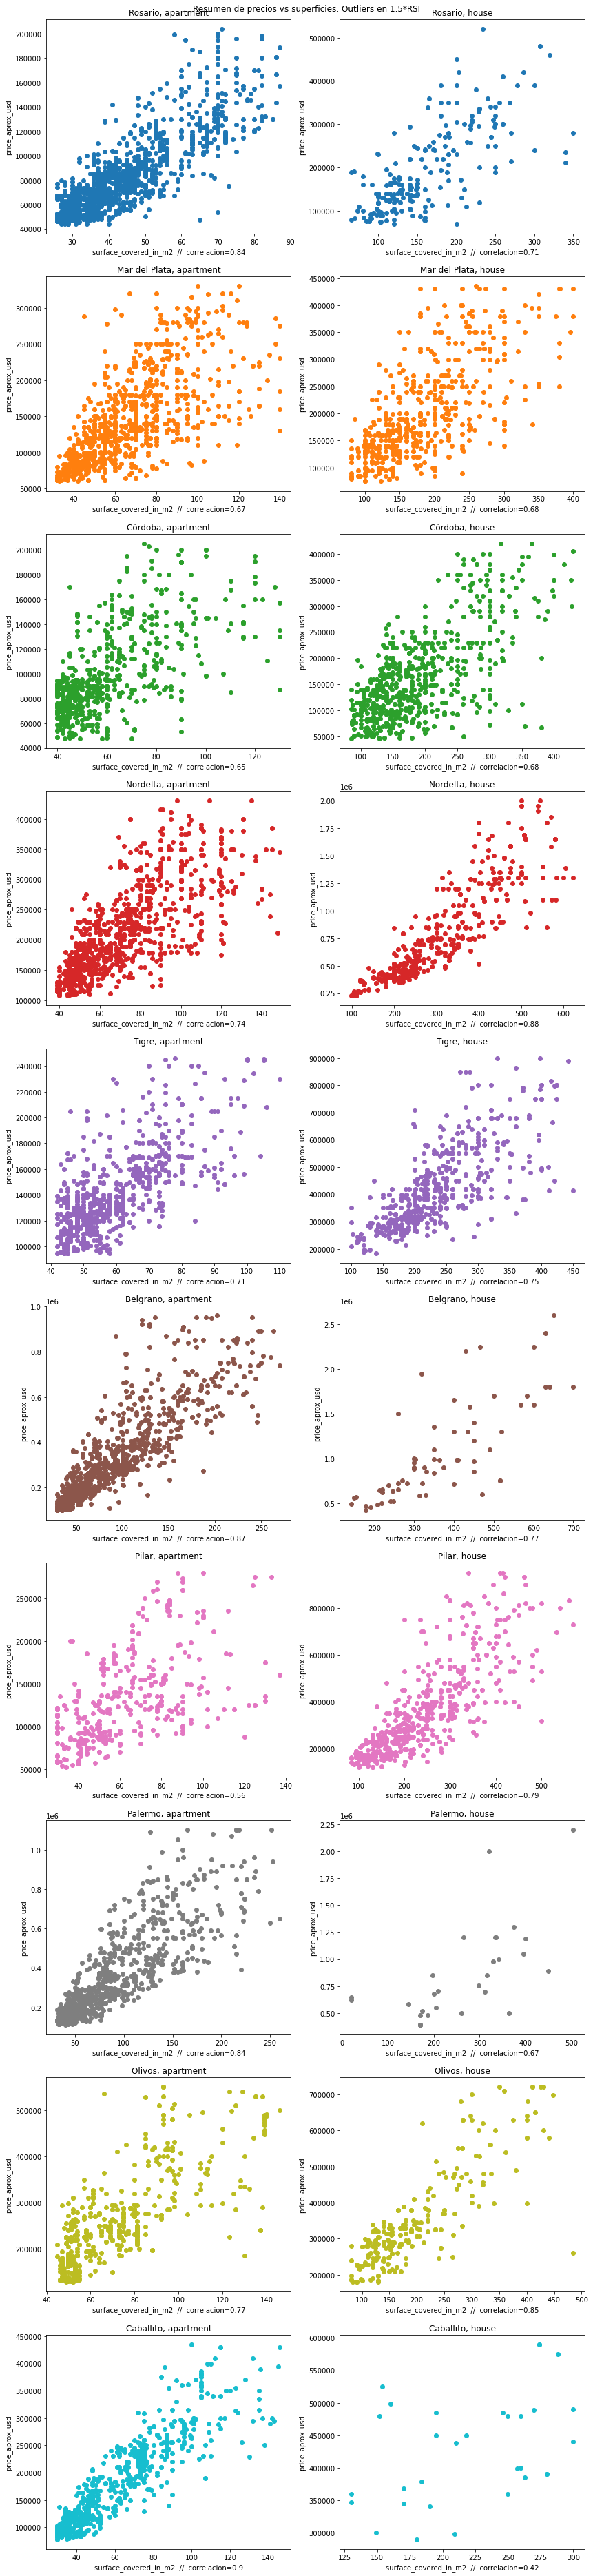

In [17]:
#Vamos a plotear, separando por groupby el data_clean

#levanto el subplot

len_tipo=len(iterar_tipo)
len_place=len(iterar_place)
fig, axs = plt.subplots(len_place,len_tipo, figsize=(7*len_tipo,6*len_place), facecolor=(1, 1, 1))

#mapa de colores para que diferenciar por place
color_map=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
            '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#bcbd22', '#17becf')

#esto es el titulo
fig.suptitle(t="Resumen de precios vs superficies. Outliers en 1.5*RSI")

#posicion relativa de los graficos, para que no se vean tan apretados.
fig.subplots_adjust(top=0.975)

#Un "j" para cada tipo
j=0 
for tipo in iterar_tipo:
    
    #Un "j" para cada place
    i=0
    for place in iterar_place:
        #reducimos para sacar todo lo que no nos sirve.
        data_reducida = data_clean.loc[:, ['place_name', 'price_aprox_usd', 'surface_covered_in_m2', 'property_type']]
        
        #agrupamos la data. filtrando por cada place.
        data_grouped = data_reducida.groupby(by = 'place_name').filter(lambda x: all(x['place_name']==place))

        #volvemos a agrupar la data. filtrando por cada tipo.
        data_grouped = data_grouped.groupby(by = 'property_type').filter(lambda x: all(x['property_type']==tipo))
        
        #aplico el filtro de ouliers para cada grupo
        data_grouped = borrar_outliers(data_grouped, ('price_aprox_usd', 'surface_covered_in_m2'))
        
        #calculo corr para meter en el grafico (si, esto no deberia estar aca... sacar, eventualmente)
        corr_grafico =  data_grouped[['surface_covered_in_m2', 'price_aprox_usd']].corr()
        corr_grafico =  corr_grafico.iloc[0,1]
        corr_grafico = round(corr_grafico, 2)

        #seteo las condiciones para cada axs[i,j]
        axs[i,j].set_title(f'{place}, {tipo}')
        axs[i,j].set_xlabel(f'surface_covered_in_m2  //  correlacion={corr_grafico}')
        axs[i,j].set_ylabel('price_aprox_usd')
        axs[i,j].scatter( x=data_grouped['surface_covered_in_m2'], y=data_grouped['price_aprox_usd'], c=color_map[i])

        #vamos al siguiente place. Muevo hacia abajo en el plot
        i+=1
    #vamos a siguiente tipo Muevo hacia la derecha en el plot
    j+=1

In [18]:
# ESTO LO COMENTO para no guardar la imagen en todos lados...
# fig.savefig('primer_dibujo')